# Fair share of errors

Consider three variables of interest:
- $S$: a sensitive variable
- $\hat{Y}$: a prediction or decision
- $Y$: the ground truth (often unobserved)

For example $Y$ could be the ability to pay for a mortgage, $\hat{Y}$ is a decision whether to offer a person a home loan, and $S$ is the person's race.

In [1]:
import pandas as pd
import numpy as np
from itertools import product

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# Illustrating the use of itertools product
for ix,value in enumerate(product(range(2), repeat=3)):
    print(ix, value)
type(value[0])

0 (0, 0, 0)
1 (0, 0, 1)
2 (0, 1, 0)
3 (0, 1, 1)
4 (1, 0, 0)
5 (1, 0, 1)
6 (1, 1, 0)
7 (1, 1, 1)


int

## Explaination of the conditions

The meaning of 0 and 1 for $Y$ and $\hat{Y}$ are pretty standard (negative and positive). We add the interpretation that a value of $S=0$ indicates a minority or disadvantaged part of the community, and $S=1$ otherwise.

If $Y$ is the same as $\hat{Y}$, then there is no bias as the predictions are correct.
- If they are both zero, then this is **true negative**, and we label them 0 and 1 based on the sensitive variable
- If they are both one, then this is **true positive**, and we label them 0 and 1 based on the sensitive variable

### The interesting cases are the **false positive** and **false negative** cases.

When the prediction is one but the ground truth is zero, this is **false positive** 
(predict positive but falsely)
- If the sensitive variable is zero, this is **A**ffirmative action. The minority group gets a positive action even though it really should not manage.
- If the sensitive variable is one, this is **C**ronyism. The majority group benefits from positive action, even though not warranted.

When the prediction is zero but the ground truth is one, this is **false negative** 
(predict negative but falsely)
- If the sensitive variable is zero, this is **D**iscrimination. The minority group is negatively affected, since they should get positive action, but they did not.
- If the sensitive variable is one, this is **B**acklash or Byproduct. The majority group is (as a side effect of decision making based on aggregate information) negatively affected.

In [9]:
def naming(y, yhat, s):
    if y == 0 and yhat == 0 and s == 0:
        return (y, yhat, s, 'TN0')
    if y == 0 and yhat == 0 and s == 1:
        return (y, yhat, s, 'TN1')
    if y == 0 and yhat == 1 and s == 0:
        return (y, yhat, s, 'A')
    if y == 0 and yhat == 1 and s == 1:
        return (y, yhat, s, 'C')
    if y == 1 and yhat == 0 and s == 0:
        return (y, yhat, s, 'D')
    if y == 1 and yhat == 0 and s == 1:
        return (y, yhat, s, 'B')
    if y == 1 and yhat == 1 and s == 0:
        return (y, yhat, s, 'TP0')
    if y == 1 and yhat == 1 and s == 1:
        return (y, yhat, s, 'TP1')

def name2position(variables):
    ix_y = np.where(np.array(variables) == 'Y')[0][0]
    ix_yhat = np.where(np.array(variables) == 'Yhat')[0][0]
    ix_s = np.where(np.array(variables) == 'S')[0][0]
    return (ix_y, ix_yhat, ix_s)

In [4]:
#variables = ['S', 'Yhat', 'Y', 'condition']
variables = ['Y', 'Yhat', 'S', 'condition']

ix_y, ix_yhat, ix_s = name2position(variables)

In [5]:
all_possibilities = pd.DataFrame(index=range(8), columns=variables, dtype='int')
for ix, value in enumerate(product([0,1], repeat=len(variables)-1)):
    all_possibilities.iloc[ix] = naming(value[ix_y], value[ix_yhat], value[ix_s]) 

# Bug in pandas, creates a dataframe of floats. Workaround.
for col in all_possibilities.columns[:-1]:
    all_possibilities[col] = pd.to_numeric(all_possibilities[col], downcast='integer')
all_possibilities

,Y,Yhat,S,name
0,0,0,0,TN0
1,0,0,1,TN1
2,0,1,0,A
3,0,1,1,C
4,1,0,0,D
5,1,0,1,B
6,1,1,0,TP0
7,1,1,1,TP1


In [6]:
def plot_cube(ax, cube_definition):
    """
    From https://stackoverflow.com/questions/44881885/python-draw-3d-cube
    """
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]


    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=50)

    ax.set_aspect('equal')
    ax.set_xlabel(variables[ix_s])
    ax.set_ylabel(variables[ix_yhat])
    ax.set_zlabel(variables[ix_y])
    ax.grid(False)
    
    return

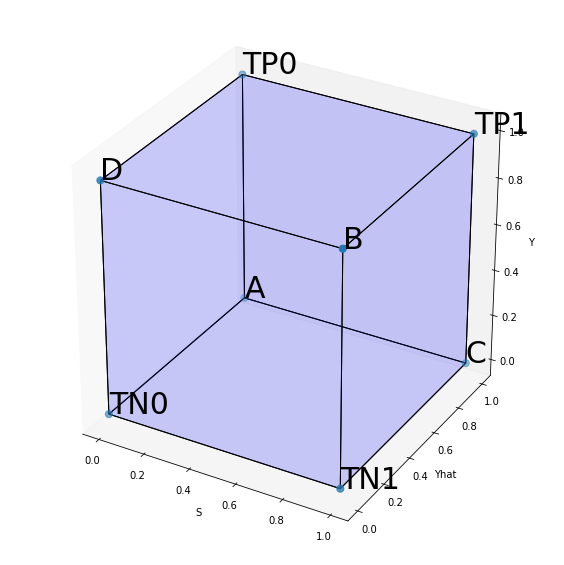

In [7]:
cube_definition = [
    (0,0,0), (0,1,0), (1,0,0), (0,0,1)
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plot_cube(ax, cube_definition)
for ix, row in all_possibilities.iterrows():
    ax.text(row[ix_s], row[ix_yhat], row[ix_y], row[3], size=30)

## Studying the trade off

Focusing on the plane traced out by A, C, B ,D, we get a two dimensional plot which provides insight into the trade off between 
1. false positives and false negatives
2. Favouritism, how much the majority group benefits

Text(1,1,'C')

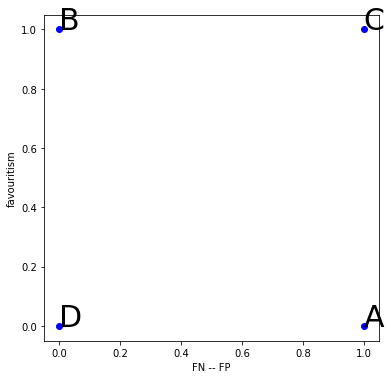

In [16]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot([0,0,1,1], [0,1,0,1], 'bo')
ax.set_xlabel('FN -- FP')
ax.set_ylabel('favouritism')
ax.text(0, 0, naming(1, 0, 0)[3], size=30)
ax.text(0, 1, naming(1, 0, 1)[3], size=30)
ax.text(1, 0, naming(0, 1, 0)[3], size=30)
ax.text(1, 1, naming(0, 1, 1)[3], size=30)